![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
# Composite Alpha Analysis Notebook
#### Licensed Under QuantConnect Platform Service Agreement v1.0. Copyright QuantConnect 2020.
#### For more information; see the Open API Specification of Alpha Streams: https://app.swaggerhub.com/apis/QuantConnect/Alpha/0.83

### Creating a Composite Alpha
Alphas can be viewed as either individual strategies or as factors to be combined to create an optimal portfolio or added to an existing strategy. In this notebook, we've performed a basic analysis where we create optimal composite Alpha portfolios using individual Alphas as factors.

In [2]:
# Import AlphaStreamRestClient and input our API credentials
from AlphaStream import AlphaStreamRestClient

clientId = "YOUR_ID"
clientToken = "YOUR_TOKEN"
client = AlphaStreamRestClient(clientId, clientToken)

#### Alpha Filtering
We elminate poorly-performing Alphas and select only the best in any individual family (authors often submit updates to Alphas). Alphas with a negative Sharpe ratio or excessive DTW distance are omitted, as are any stopped Alphas or those made by QuantConnect for testing purposes.

In [3]:
# Fetch all alphas
all_alphas = client.GetAlphaList()

# Map IDs to family as best as possible -- we only want to take the best performing in each family
family_map = {}

for x in all_alphas:
    torf = True
    alpha = client.GetAlphaById(x)
    
    # Filter our stopped Alphas, negative SR Alphas, and those with bad OOS DTW
    if alpha.Status != 'running':
        continue
    if alpha.Name is None:
        continue
    if alpha.SharpeRatio is None:
        continue
    if alpha.SharpeRatio < 0.5:
        continue
    if (datetime.utcnow() - alpha.ListedTime).days < 60:
        continue
    if alpha.OutOfSampleDtwDistance is None:
        continue
    if alpha.OutOfSampleDtwDistance > 0.4:
        continue
    
    # Filter out QC authors
    authors = alpha.Authors
    for auth in authors:
        if auth.Id in ['2b2552a1c05f83ba4407d4c32889c367', '604b579e6e335059d878dc6b412d1c15']:
            torf = False
    
    if not torf:
        continue    
    
    # Add Alpha and SR to collection
    if alpha.Name not in family_map.keys():
        family_map[alpha.Name] = [(x, alpha.SharpeRatio)]
    else:
        family_map[alpha.Name] += [(x, alpha.SharpeRatio)]

In [4]:
# Sort alphas in each family by SR, then take best
best_in_family = []
for name, tuples in family_map.items():
    sorted_tuples = sorted(tuples, key = lambda x:x[1], reverse=True)
    best_in_family.append(sorted_tuples[0][0])

In [5]:
# Build data frame of equity curves for the selected Alphas
equity_curves = pd.DataFrame()
for x in best_in_family:
    equity = client.GetAlphaEquityCurve(x)
    curve = equity.drop('sample', axis = 1).squeeze(axis = 1)
    total_return = (curve.iloc[-1] - curve.iloc[0]) / curve.iloc[0]
    if total_return <= 0:
        continue
    curve.name = x
    curve = curve.resample('D').mean()
    equity_curves = equity_curves.join(curve, how = 'outer')

#### Testing
We try every unique combination of 3 Alphas and create an equally-weighted portfolio. The composite portfolio is considered successful if its Sortino ratio is greater than any of the Sortino ratios of the individual Alphas it is made of. Once all combinations are tested, the final list is sorted based on the composite portfolio's Sortino ratio.

In [6]:
# Get all unique combinations of Alphas
alpha_ids = list(equity_curves.columns)
total_combinations = list(set(combinations(alpha_ids, 3)))
possible_combinations = []

# Iterate over all combinations and select those whose composite Sortino ratio is larger than any individual Sortino ratio
for combo in total_combinations:
    curves = equity_curves[list(combo)].copy().ffill().dropna()  # Get equity curves of the Alphas
    curves = curves/curves.iloc[0]  # Scale each to have start value of 1
    returns = curves.pct_change().dropna()
    composite_returns = returns.sum(axis = 1)
    new_curve = (curves/3).sum(axis = 1)  # Equally weight each curve to create a synthetic portfolio
    new_curve.name = 'Composite'
    sortinos = []
    for col in returns.columns:
        sortinos += [Sortino(returns[col])]
    max_sortino = max(sortinos)

    new_returns = new_curve.pct_change()
    new_sortino = Sortino(new_returns)
    
    if new_sortino > max_sortino:
        possible_combinations.append((new_sortino, combo, new_curve, curves))

In [7]:
# Sort final combinations by Sortino ratio
sorted_final_combinations = sorted(possible_combinations, key = lambda k: k[0], reverse = True)

#### Basic Analysis
We perform basic analysis on the composite portfolio equity curve. Below, we plot the equity curve, cumulative returns, and various other properties of one of the composite portfolios.

In [8]:
# Take the a composite Alpha
sortino, ids, new_curve, curves = sorted_final_combinations[300]

# Use custom Equity class to assist in plotting
equity = Equity(new_curve, curves, list(ids), 'SPY')

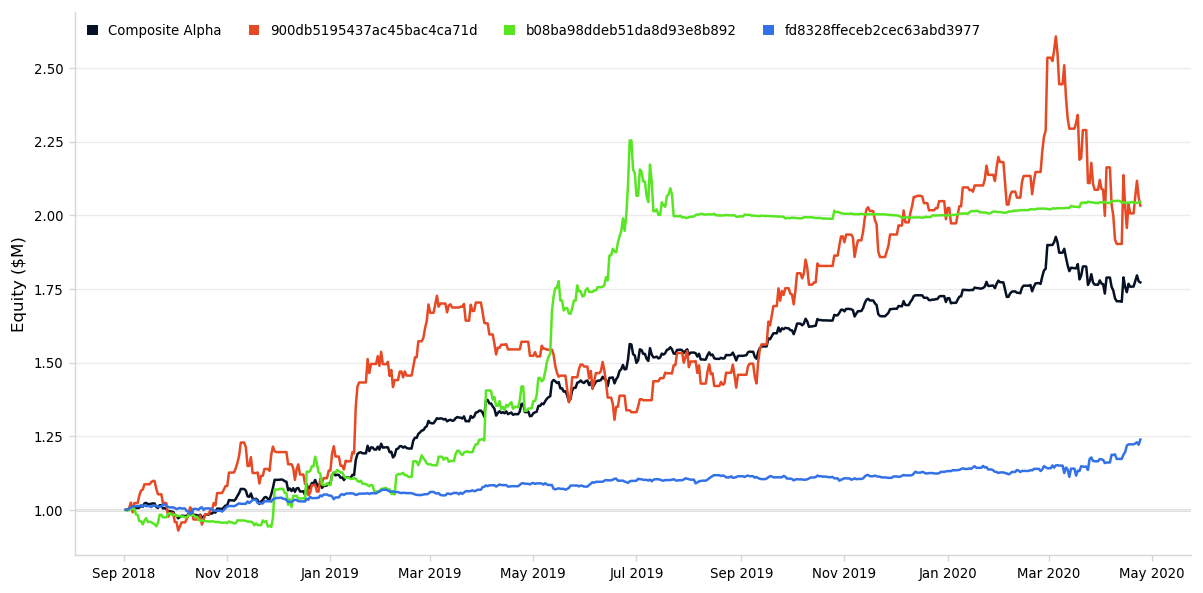

In [9]:
# Plot the composite equity curve against the individual Alpha curves
equity.GetEquityCurve()

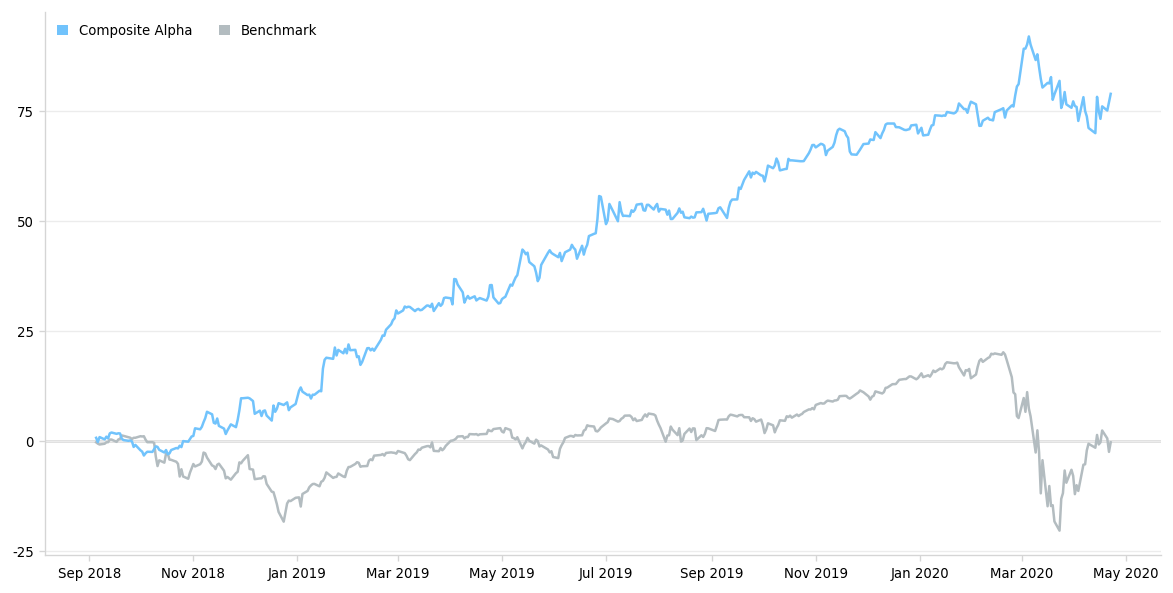

In [10]:
# Get cumulative returns, plot against benchmark
equity.GetCumulativeReturns()

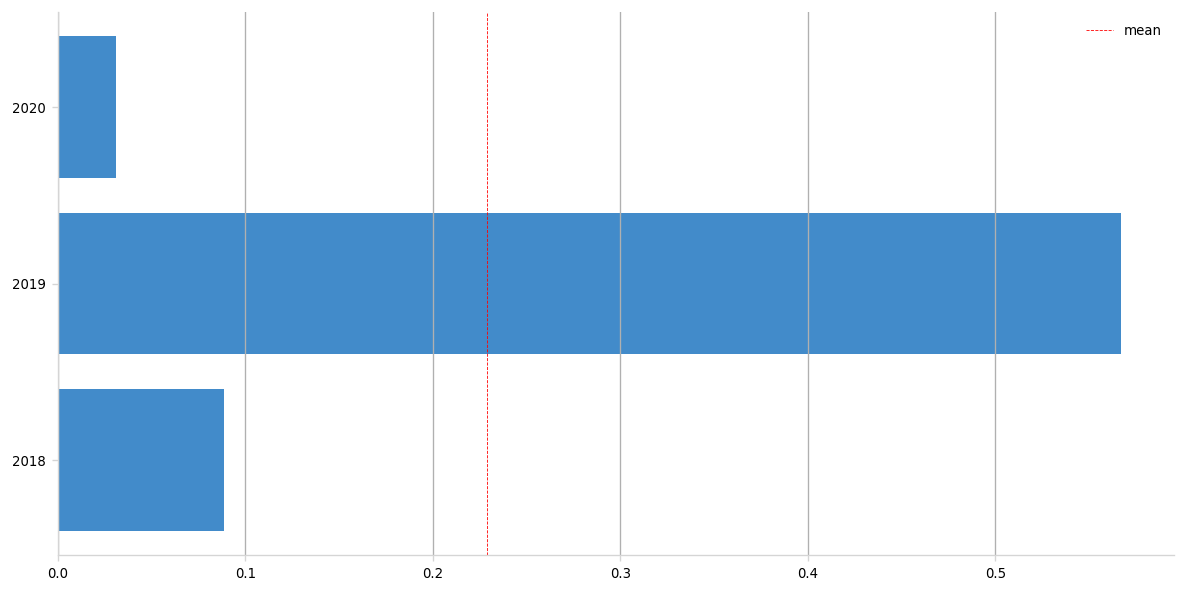

In [11]:
# Get annual returns
equity.GetAnnualReturns()

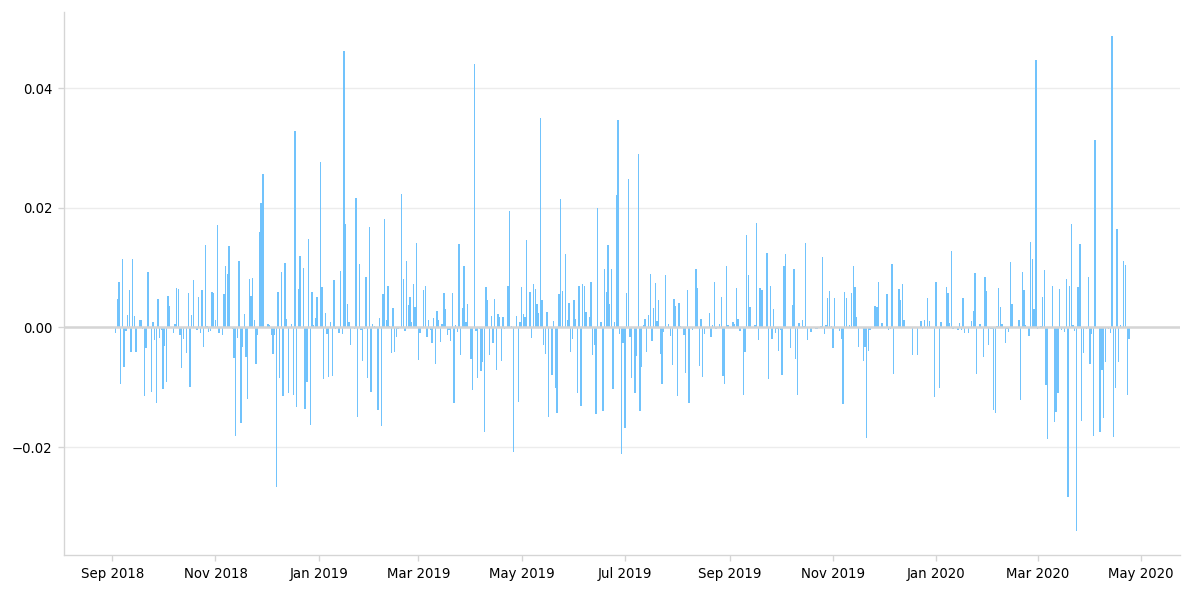

In [12]:
# Get daily returns
equity.GetDailyReturns()

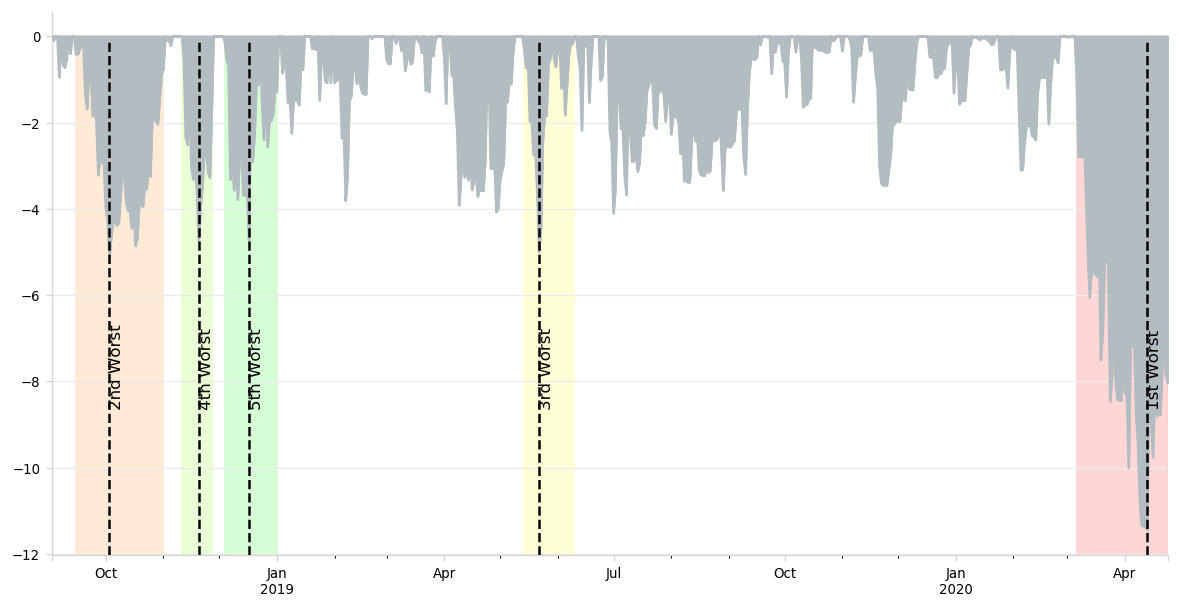

In [13]:
# Plot equity drawdown
equity.GetDrawdown()

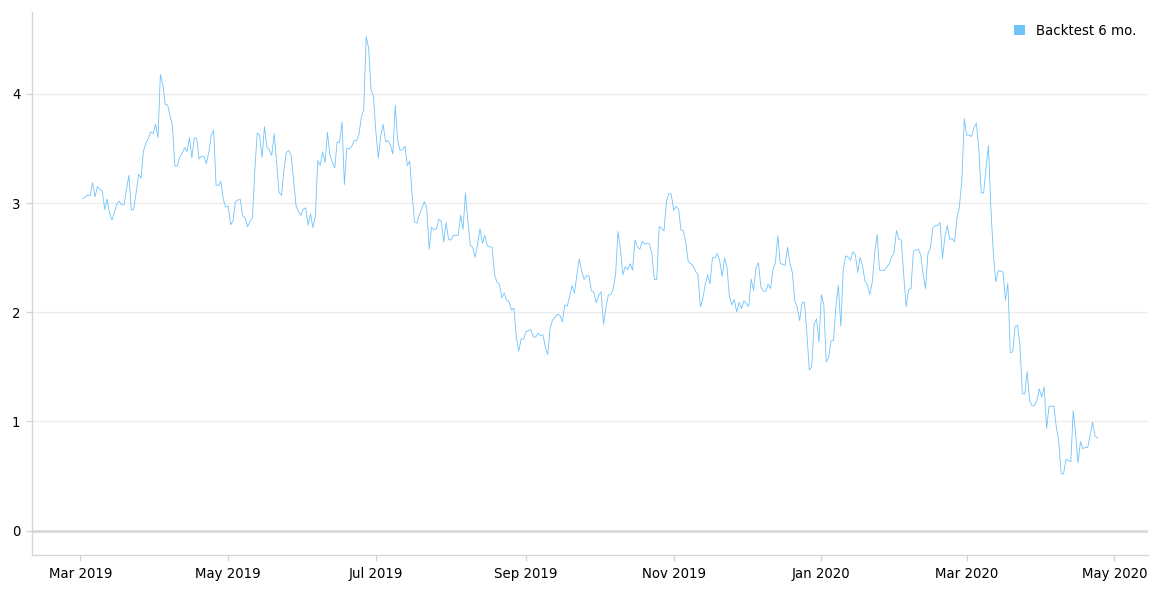

In [14]:
# Get rolling 6-month Sharpe ratio
equity.GetRollingSharpeRatio()

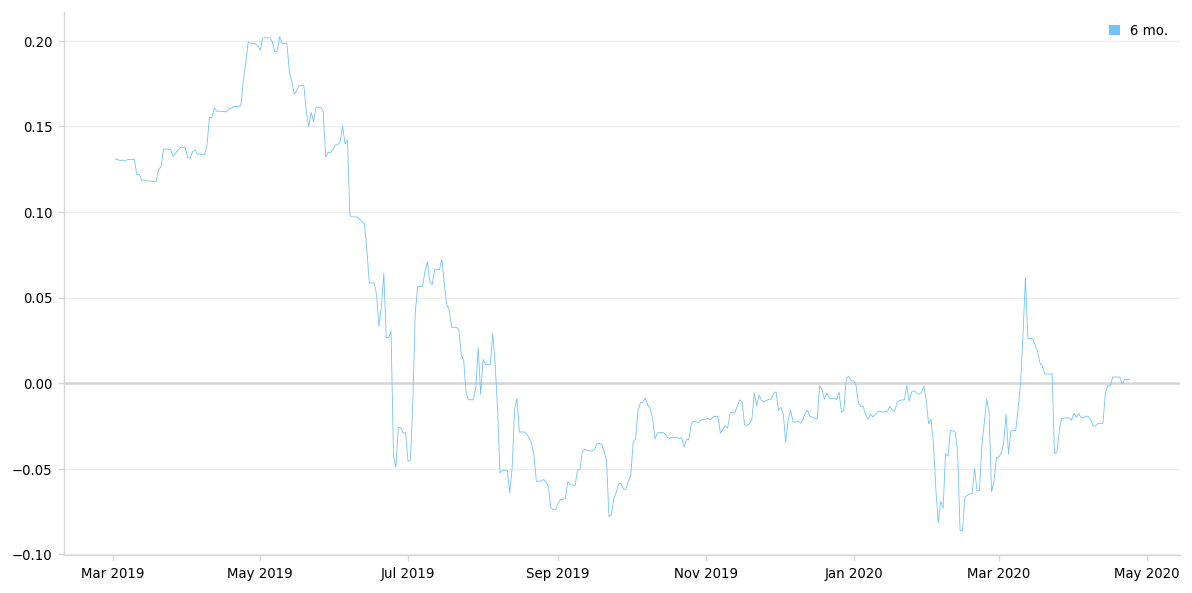

In [15]:
# Get rolling 6-month Beta
equity.GetRollingBeta()

In [16]:
# Get Maximum Drawdown
GetMaxDrawdown(new_curve)

0.115

### Appendix
Please run this section of code first so the rest of the cells will run successfully

In [1]:
import re
import sys
import json
import requests
import operator
import numpy as np
import pandas as pd
from math import ceil
from time import time, sleep
from itertools import groupby
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import combinations
from matplotlib.lines import Line2D
from scipy.stats.stats import pearsonr
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from dateutil.relativedelta import relativedelta
from pandas.plotting import register_matplotlib_converters
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

register_matplotlib_converters()

# Function to calculate beta
def Beta(returns_data):
    corr = returns_data.corr()['Composite'][1]
    std_ratio = returns_data['SPY'].std() / returns_data['Composite'].std()
    return corr * std_ratio

# Function to calculate Sortino ratio
def Sortino(curve):
    ann_ret = ((np.mean(curve) + 1) ** 252) - 1
    ann_down_std = np.std(curve.loc[curve < 0]) * np.sqrt(252)
    return ann_ret / ann_down_std if ann_down_std is not 0 else None

# Get Alpha's maximum drawdown
def GetMaxDrawdown(equityCurve):
    curve = equityCurve.values
    i = np.argmax(np.maximum.accumulate(curve) - curve)
    j = np.argmax(curve[:i])
    return round(abs((curve[i]/curve[j]) - 1), 3)

# Code to get benchmark data
def _get_crumbs_and_cookies(stock = None):
    """
    get crumb and cookies for historical data csv download from yahoo finance

    parameters: stock - short-handle identifier of the company

    returns a tuple of header, crumb and cookie
    """
    if stock is None:
        raise TypeError(f'Stock argument must be string')
    else:
        url = 'https://finance.yahoo.com/quote/{}/history'.format(stock)
    with requests.session():
        header = {'Connection': 'keep-alive',
                  'Expires': '-1',
                  'Upgrade-Insecure-Requests': '1',
                  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) \
                   AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
                  }

        website = requests.get(url, headers=header)
        soup = BeautifulSoup(website.text, 'lxml')
        crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))

        return (header, crumb[0], website.cookies)

# Update forex benchmark
def GetSGCTA():
    url = "https://wholesale.banking.societegenerale.com/fileadmin/indices_feeds/CTA_Historical.xls"
    with requests.session():
        website = requests.get(url)
        file = website.text.split('\n')[:-1]
    close = [line.split('\t')[1] for line in file[1:]]
    date = [datetime.strptime(line.split('\t')[0], '%Y/%m/%d') for line in file[1:]]
    data_frame = pd.DataFrame({'Date': date, 'Close': close})
    if not data_frame.empty:
        return data_frame
    else:
        raise Exception('SGCTA data frame empty.')

# Update equities benchmark
def GetBenchmark(ticker):
    start_date = '946684800'
    now = datetime.utcnow()
    end_date = int(datetime.timestamp(datetime(now.year, now.month, now.day, 0, 0, 0)))

    header, crumb, cookies = _get_crumbs_and_cookies(f'{ticker.upper()}')
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker.upper()}?period1={start_date}&period2={end_date}&interval=1d&events=history&crumb={crumb}"
    with requests.session():
        website = requests.get(url, headers=header, cookies=cookies)
        file = website.text.split('\n')[:-1]
    date = [datetime.strptime(line.split(',')[0], '%Y-%m-%d') for line in file[1:]]
    close = [float(line.split(',')[5]) for line in file[1:]]
    data_frame = pd.DataFrame({'Date': date, f'{ticker}': close})
    if not data_frame.empty:
        data_frame = data_frame.set_index('Date')
        data_frame.index = data_frame.index.to_pydatetime()
        return data_frame
    else:
        raise Exception(f'{ticker.upper()} data frame empty.')
        

        
        
        
        
# class to plot equity
class Equity:
    def __init__(self, equity, curves, ids, benchmarkTicker):

        
        self.equityCurve = equity
        self.benchmarkTicker = benchmarkTicker
        self.individualCurves = curves
        self.ids = ids
        
        torf = True
        while torf:
            try:
                self.benchmark = GetBenchmark(benchmarkTicker)
                torf = False
            except:
                continue
        
    def GetEquityCurve(self):
        # Get the equity curve
        compositeCurve = self.equityCurve.copy()
        data = compositeCurve.to_frame().join(self.individualCurves, how = 'outer')

        labels = ['Composite Alpha'] + self.ids
        rectangles = []
        colors = ["#061125", "#E64923", "#58E623", "#3372E6"]
        for i in colors:
            rectangles.append(plt.Rectangle((0, 0), 1, 1, fc=i))
        
        plt.figure(figsize=(12, 6), dpi= 120)
        ax = plt.gca()

        for col, color, lab in zip(data.columns, colors, labels):
            plt.plot(data.index.values, data[col].values, color = color, label = lab)
        
        plt.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                  frameon=False, fontsize=8, ncol=len(labels), loc = 'upper left')
        plt.xticks(rotation=0, ha='center', fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
        plt.axhline(y=1, color='#d5d5d5', zorder=1)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        plt.xlabel("")
        ax.yaxis.grid(True, color="#ececec")
        plt.ylabel('Equity ($M)', fontsize = 10)
        plt.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                  frameon=False, fontsize=8, ncol=len(labels), loc = 'upper left')
        
        plt.show()
        
    def GetCumulativeReturns(self):
        # Add the SPY benchmark to the plot and plot cumulative returns
        benchmark = self.benchmark.copy()
        equityData = self.equityCurve
        
        data = equityData.to_frame().join(benchmark, how = 'inner')
        data = ((data.pct_change() + 1).cumprod() - 1)*100
        
        labels = ['Composite Alpha', 'Benchmark']
        rectangles = []
        colors = ["#71c3fc", "#b3bcc0"]
        for i in range(2):
            rectangles.append(plt.Rectangle((0, 0), 1, 1, fc=colors[i]))
            
        
        plt.figure(figsize=(12, 6), dpi= 120)
        ax = plt.gca()
        plt.plot(data[f'{self.benchmarkTicker}'].index.values, data[f'{self.benchmarkTicker}'].values, color = '#b3bcc0', label = "SPY")
        plt.plot(data[f'{data.columns[0]}'].index.values, data[f'{data.columns[0]}'].values, color = '#71c3fc', label = "Composite Alpha")
        plt.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                  frameon=False, fontsize=8, ncol=len(labels), loc = 'upper left')
        plt.xticks(rotation=0, ha='center', fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.yaxis.set_major_locator(MaxNLocator(6))
        plt.axhline(y=0, color='#d5d5d5', zorder=1)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        plt.ylabel("")
        plt.xlabel("")
        ax.yaxis.grid(True, color="#ececec")
        plt.show()
        
    def GetAnnualReturns(self):
        years = list(set([x.year for x in self.equityCurve.index.to_pydatetime()]))
        data = self.equityCurve.copy()
        returns = []
        for year in years:
            df = data.loc[[x.year == year for x in data.index.to_pydatetime()]]
            ret = (df[-1]/df[0]) - 1
            returns.append(ret)
        time = years

        plt.figure(figsize=(12, 6), dpi= 120)
        ax = plt.gca()
        ax.barh(time, returns, color = ["#428BCA"])
        fig = ax.get_figure()
        plt.xticks(rotation=0, ha='center', fontsize=8)
        plt.yticks(fontsize=8)
        plt.axvline(x=0, color='#d5d5d5', linewidth=0.5)
        vline = plt.axvline(x=np.mean(returns), color="red", ls="dashed", label="mean", linewidth=0.5)
        plt.legend([vline], ["mean"], loc='upper right', frameon=False, fontsize=8)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_yticks(time)
        plt.xlabel("")
        plt.ylabel("")
        ax.xaxis.grid(True)
        plt.show()
        
    def GetDrawdown(self):
        data = self.equityCurve.copy().to_frame()
        data["Drawdown"] = 1
        lastPeak = data.iloc[0,0]
        for i in range(len(data)):
            if data.iloc[i,0] < lastPeak:
                data.iloc[i,1] = data.iloc[i,0]/lastPeak
            else:
                lastPeak = data.iloc[i,0]
        data["DDGroup"] = 0
        tmp = 0
        for i in range(1,len(data)):
            if data.iloc[i,1] != 1:
                data.iloc[i,2] = tmp
            else:
                continue
            if data.iloc[i-1,1] == 1:
                tmp += 1
                data.iloc[i,2] = tmp
        data["index"] = [i for i in range(len(data))]
        tempFrame = pd.DataFrame.from_dict({'MDD':data.groupby([data["DDGroup"]])['Drawdown'].min(),
                                      'Offset':data.groupby([data["DDGroup"]])['Drawdown'].apply(lambda x: np.where(x == min(x))[0][0]),
                                      'Start':data.groupby([data["DDGroup"]])['index'].first(),
                                      'End':data.groupby([data["DDGroup"]])['index'].last()})
        tempFrame.drop(tempFrame.index[[0]],inplace = True)
        tempFrame.sort_values("MDD",inplace = True)
        data = (data["Drawdown"] - 1)*100

        fig=plt.figure(figsize=(12, 6), dpi= 120)
        colors = ["#FFCCCCCC","#FFE5CCCC","#FFFFCCCC","#E5FFCCCC","#CCFFCCCC"]
        text = ["1st Worst","2nd Worst","3rd Worst","4th Worst","5th Worst"]
        ax = data.plot(color = '#b3bcc0',zorder = 2)
        ax.fill_between(data.index.values,data,0, color = '#b3bcc0',zorder = 3)
        for i in range(min(len(tempFrame),5)):
            start = data.index.values[int(tempFrame.iloc[i]["Start"])]
            end = data.index.values[int(tempFrame.iloc[i]["End"])]
            mid = data.index.values[int(tempFrame.iloc[i]["Offset"])+int(tempFrame.iloc[i]["Start"])]
            plt.axvspan(start, end,0,0.95, color = colors[i],zorder = 1)
            plt.axvline(mid, 0,0.95, ls = "dashed",color ="black", zorder = 4)
            plt.text(mid,min(data)*0.75,text[i], rotation = 90, zorder = 4)


        fig = ax.get_figure()
        plt.xticks(rotation = 0,ha = 'center', fontsize = 8)
        plt.yticks(fontsize = 8)
        plt.ylabel("")
        plt.xlabel("")
#         ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
        plt.axhline(y = 0, color = '#d5d5d5', zorder=1)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.grid(True, color = "#ececec")
        plt.show()
        
        
    def GetDailyReturns(self):
        def GetDailyReturns(returns = [[],[]], live_returns = [[],[]], live_color = "#ff9914", backtest_color = "#71c3fc", gray = "#b3bcc0"):

            plt.figure(figsize=(12, 6), dpi= 120)
            ax = plt.gca()

            # Backtest
            ax.bar(returns[0][:min(len(returns[0]),len(returns[1]))], returns[1], color = backtest_color, zorder = 2)
            # Live
            ax.bar(live_returns[0][:min(len(live_returns[0]),len(live_returns[1]))], live_returns[1], color=live_color,zorder=2)

            # Need to handle this since we don't use a legend if it is only backtesting
            if len(live_returns[0]) > 0:
                rectangles = [plt.Rectangle((0, 0), 1, 1, fc=backtest_color), plt.Rectangle((0, 0), 1, 1, fc=live_color)]
                ax.legend(rectangles, [label for label in ['Backtest', "Live"]], handlelength=0.8, handleheight=0.8,
                          frameon=False, fontsize=8)

            fig = ax.get_figure()
            ax.xaxis_date()
            plt.xticks(rotation = 0,ha = 'center', fontsize = 8)
            plt.yticks(fontsize = 8)
            plt.ylabel("")
            plt.xlabel("")
            ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
            plt.axhline(y = 0, color = '#d5d5d5')
            plt.setp(ax.spines.values(), color='#d5d5d5')
            plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_axisbelow(True)
            ax.yaxis.grid(True, color = "#ececec")
            plt.show()

        returns = self.equityCurve.pct_change().dropna()
        time = [pd.Timestamp(x).to_pydatetime() for x in returns.index.values]
        data = list(returns.values)
        backtest = [time, data]

        GetDailyReturns(backtest)
        
    
    def GetRollingSharpeRatio(self):
        
        def GetRollingSharpeRatioPlot(data = [[],[]], live_data = [[],[]], live_color = "#ff9914", backtest_color = "#71c3fc"):
            if len(data[0]) == 0:
                fig = plt.figure()
                plt.show()

            labels = ['Backtest 6 mo.']
            rectangles = [plt.Rectangle((0, 0), 1, 1, fc=backtest_color)]
            if len(live_data[0]) > 0:  # Need to handle this...
                rectangles += [plt.Rectangle((0, 0,), 1, 1, fc=live_color)]
                labels += ["Live 6 mo."]

            plt.figure(figsize=(12, 6), dpi= 120)
            ax = plt.gca()
            ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

            # Backtest
            ax.plot(data[0][:min(len(data[0]),len(data[1]))], data[1], color = backtest_color, linewidth = 0.5, zorder = 2)

            # Live
            ax.plot(live_data[0][:min(len(live_data[0]), len(live_data[1]))], live_data[1], color=live_color, linewidth=0.5, zorder=2)

            leg = ax.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                            frameon=False, fontsize=8)
            for line in leg.get_lines(): line.set_linewidth(3)
            plt.axhline(y=0, color='#d5d5d5', zorder=1)
            plt.setp(ax.spines.values(), color='#d5d5d5')
            ax.tick_params(axis='both', labelsize=8, labelrotation=0)
            plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
            plt.ylabel("")
            plt.xlabel("")
            ax.set_axisbelow(True)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.yaxis.grid(True, color="#ececec")
            plt.show()
        
        curve = self.equityCurve.copy()
        nMonths = 6
        firstDate = curve.index.to_pydatetime()[0]
        data = [[],[]]
        for date in curve.index.to_pydatetime():
            nMonthsAgo = date + relativedelta(months=-nMonths)
            if nMonthsAgo < firstDate:
                continue
            data_frame = curve.loc[curve.index.to_pydatetime() <= date]
            data_frame = data_frame.loc[nMonthsAgo <= data_frame.index.to_pydatetime()]

            dailyReturns = data_frame.pct_change().dropna()
            annualReturn = ((np.mean(dailyReturns) + 1) ** 252) - 1
            annualVolatility = np.std(dailyReturns) * np.sqrt(252)
            sharpe = annualReturn / annualVolatility
            if isinstance(sharpe, float):
                data[1].append(sharpe)
                data[0].append(date)
                       
        GetRollingSharpeRatioPlot(data)
        
        
    def GetRollingBeta(self):
        curve = self.equityCurve.copy()
        benchmarkCurve = self.benchmark.copy()

        nMonths = 6
        firstDate = curve.index.to_pydatetime()[0]
        data = [[],[]]
        for date in curve.index.to_pydatetime():
            nMonthsAgo = date + relativedelta(months=-nMonths)
            if nMonthsAgo < firstDate:
                continue
            data_frame = curve.loc[curve.index.to_pydatetime() <= date]
            data_frame = data_frame.loc[nMonthsAgo <= data_frame.index.to_pydatetime()]

            bmark = benchmarkCurve.loc[benchmarkCurve.index.to_pydatetime() <= date]
            bmark = bmark.loc[nMonthsAgo <= bmark.index.to_pydatetime()]

            if bmark.empty:
                continue

            dailyReturns = data_frame.pct_change().dropna()
            benchmarkReturns = bmark.pct_change().dropna()
            joinedData = dailyReturns.to_frame().join(benchmarkReturns, how = 'outer').dropna()    
            beta = joinedData.cov()['Composite'][1]/benchmarkReturns.var().values[0]
            if isinstance(beta, float):
                data[1].append(beta)
                data[0].append(date)
                    
                    
        def GetRollingBetaPlot(data = [[],[],[]], live_data = [[],[],[]]):
            if len(data[0]) == 0:
                fig = plt.figure()
                plt.show()


            labels = ['6 mo.']
            rectangles = [plt.Rectangle((0, 0), 1, 1, fc="#71c3fc")]
            if len(live_data[0]) > 0:
                labels += ['Live 6 mo.']
                rectangles += [plt.Rectangle((0, 0), 1, 1, fc="#ff9914")]

            plt.figure(figsize=(12, 6), dpi= 120)
            ax = plt.gca()
            fig = ax.get_figure()
            ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

            # Backtest
            ax.plot(data[0], data[1], linewidth = 0.5, color = "#71c3fc")

            leg = ax.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                            frameon=False, fontsize=8, ncol=1)
            for line in leg.get_lines(): line.set_linewidth(3)
            plt.axhline(y=0, color='#d5d5d5', zorder=1)
            plt.setp(ax.spines.values(), color='#d5d5d5')
            ax.tick_params(axis='both', labelsize=8, labelrotation=0)
            plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
            plt.xlabel("")
            plt.ylabel("")
            ax.set_axisbelow(True)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.yaxis.grid(True, color="#ececec")
            plt.show()
            
        GetRollingBetaPlot(data)